<a href="https://colab.research.google.com/github/jo-cho/advances_in_financial_machine_learning/blob/master/Chapter_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Chapter 10 Bet Sizing

In [0]:
import numpy as np
import pandas as pd
import datetime as dt

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns; sns.set()

import scipy.stats as ss
from scipy.stats import norm, moment

from dask.diagnostics import ProgressBar
ProgressBar().register()  # ready progress bar once in notebook for later calculations

from sklearn.neighbors import KernelDensity

In [0]:
# 멀티프로세싱

import time
import sys

def linParts(numAtoms,numThreads):
    # partition of atoms with a single loop
    parts=np.linspace(0,numAtoms,min(numThreads,numAtoms)+1)
    parts=np.ceil(parts).astype(int)
    return parts

def nestedParts(numAtoms,numThreads,upperTriang=False):
    # partition of atoms with an inner loop
    parts,numThreads_=[0],min(numThreads,numAtoms)
    for num in range(numThreads_):
        part=1+4*(parts[-1]**2+parts[-1]+numAtoms*(numAtoms+1.)/numThreads_)
        part=(-1+part**.5)/2.
        parts.append(part)
    parts=np.round(parts).astype(int)
    if upperTriang: # the first rows are heaviest
        parts=np.cumsum(np.diff(parts)[::-1])
        parts=np.append(np.array([0]),parts)
    return parts
# =======================================================
# single-thread execution for debugging [20.8]
def processJobs_(jobs):
    # Run jobs sequentially, for debugging
    out=[]
    for job in jobs:
        out_=expandCall(job)
        out.append(out_)
    return out
# =======================================================
# Example of async call to multiprocessing lib [20.9]
import multiprocessing as mp
import datetime as dt

#________________________________
def reportProgress(jobNum,numJobs,time0,task):
    # Report progress as asynch jobs are completed
    msg=[float(jobNum)/numJobs, (time.time()-time0)/60.]
    msg.append(msg[1]*(1/msg[0]-1))
    timeStamp=str(dt.datetime.fromtimestamp(time.time()))
    msg=timeStamp+' '+str(round(msg[0]*100,2))+'% '+task+' done after '+ \
        str(round(msg[1],2))+' minutes. Remaining '+str(round(msg[2],2))+' minutes.'
    if jobNum<numJobs:sys.stderr.write(msg+'\r')
    else:sys.stderr.write(msg+'\n')
    return
#________________________________
def processJobs(jobs,task=None,numThreads=24):
    # Run in parallel.
    # jobs must contain a 'func' callback, for expandCall
    if task is None:task=jobs[0]['func'].__name__
    pool=mp.Pool(processes=numThreads)
    outputs,out,time0=pool.imap_unordered(expandCall,jobs),[],time.time()
    # Process asyn output, report progress
    for i,out_ in enumerate(outputs,1):
        out.append(out_)
        reportProgress(i,len(jobs),time0,task)
    pool.close();pool.join() # this is needed to prevent memory leaks
    return out
# =======================================================
# Unwrapping the Callback [20.10]
def expandCall(kargs):
    # Expand the arguments of a callback function, kargs['func']
    func=kargs['func']
    del kargs['func']
    out=func(**kargs)
    return out
# =======================================================
# Pickle Unpickling Objects [20.11]
def _pickle_method(method):
    func_name=method.im_func.__name__
    obj=method.im_self
    cls=method.im_class
    return _unpickle_method, (func_name,obj,cls)
#________________________________
def _unpickle_method(func_name,obj,cls):
    for cls in cls.mro():
        try:func=cls.__dict__[func_name]
        except KeyError:pass
        else:break
    return func.__get__(obj,cls)
#________________________________
def mpPandasObj(func,pdObj,numThreads=24,mpBatches=1,linMols=True,**kargs):
    '''
    Parallelize jobs, return a dataframe or series
    + func: function to be parallelized. Returns a DataFrame
    + pdObj[0]: Name of argument used to pass the molecule
    + pdObj[1]: List of atoms that will be grouped into molecules
    + kwds: any other argument needed by func
    Example: df1=mpPandasObj(func,('molecule',df0.index),24,**kwds)
    '''
    import pandas as pd
    #if linMols:parts=linParts(len(argList[1]),numThreads*mpBatches)
    #else:parts=nestedParts(len(argList[1]),numThreads*mpBatches)
    if linMols:parts=linParts(len(pdObj[1]),numThreads*mpBatches)
    else:parts=nestedParts(len(pdObj[1]),numThreads*mpBatches)

    jobs=[]
    for i in range(1,len(parts)):
        job={pdObj[0]:pdObj[1][parts[i-1]:parts[i]],'func':func}
        job.update(kargs)
        jobs.append(job)
    if numThreads==1:out=processJobs_(jobs)
    else: out=processJobs(jobs,numThreads=numThreads)
    if isinstance(out[0],pd.DataFrame):df0=pd.DataFrame()
    elif isinstance(out[0],pd.Series):df0=pd.Series()
    else:return out
    for i in out:df0=df0.append(i)
    df0=df0.sort_index()
    return df0

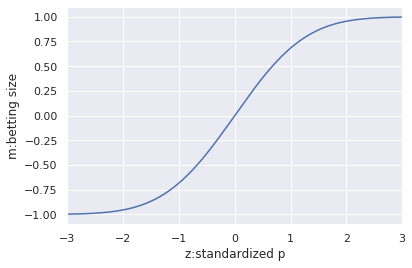

In [5]:
# Figure 10.1

p = np.linspace(0.001,1,1000,endpoint=False)
z = (p-0.5)/(np.sqrt(p*(1-p)))
Z_z = norm.cdf(z)
m = (2 * Z_z -1) # np.sign(x)=1 always? increasing function
plt.plot(z,m)
plt.xlim(-3,3)
plt.xlabel('z:standardized p');
plt.ylabel('m:betting size');

# Exercises

In [1]:
cd /content

/content


## 1. Using the formulation in Section 10.3, plot the bet size (m) as a function of the maximum predicted probability $(\tilde{p})$ when ‖X‖ = 2, 3,…, 10

$$ z = \frac{\tilde{p}− \frac{1}{‖X‖}}{\sqrt{p(1-\tilde{p})}} ∼Z $$

$$ m = x (2Z [z] − 1) $$


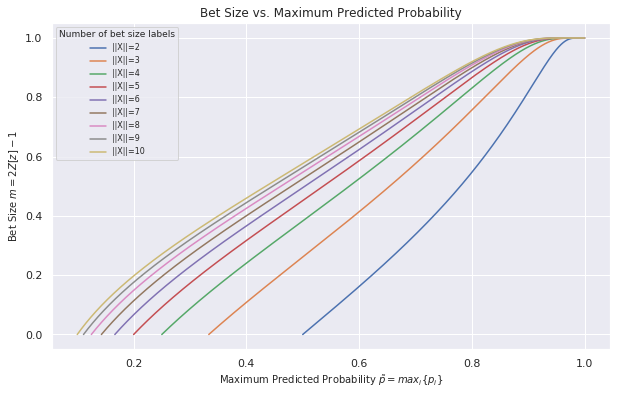

In [13]:
# This code is cloned from github.com/hudson-and-thames/research

listX = range(2, 11)  # array of IIXII
n = 10000

fig_10_1, ax_10_1 = plt.subplots(figsize=(10, 6))

for X in listX:
    # possible range for maximum predicted probability, [1/||X||, 1]
    p = np.linspace(1/X, 1, n, endpoint=False)  # range of maximum predicted probabilities to plot
    z = (p - 1/X) / (p*(1-p))**0.5
    m = 2 * norm.cdf(z) - 1
    ax_10_1.plot(p, m, label=f"||X||={X}")

ax_10_1.set_ylabel("Bet Size $m=2Z[z]-1$", fontsize=10)
ax_10_1.set_xlabel(r"Maximum Predicted Probability $\tilde{p}=max_i${$p_i$}", fontsize=10)
ax_10_1.set_title("Bet Size vs. Maximum Predicted Probability", fontsize=12)
ax_10_1.legend(loc="upper left", fontsize=8, title="Number of bet size labels", title_fontsize=9)

plt.show()

예측된 최대 확률로 나타낸 bet size의 함수이다. 예측된 최대 확률이 높으면 bet size가 커진다. 최대확률이 $\frac{1}{||X||}$ 보다 작으면 베팅하지 않는다. 

--Note--

$||X||$가 클수록 bet size를 1로 놓는 순간이 빠르다, since the greater number of alternative bets spreads the remaining probability much thinner, leading to a greater confidence in that with the maximum predicted probability.

## 2. Draw 10,000 random numbers from a uniform distribution with bounds U[.5, 1.]. (Author's note: These exercises are intended to simulate dynamic bet sizing of a long-only strategy.)

In [0]:
# draw random numbers from a uniform distribution (all bets are long)
np.random.seed(123)
n = 10000
P_t = np.random.uniform(0.01, 1., n)  # array of random from uniform dist.

#0.5보다 큰 것만 뽑는다는건 long만 생각한다는 것이다.
#그래서 그냥 U[0,1]로 간다. 0이 나오면 안돼서 0.01로 간다.

### (a) Compute bet sizes m for $||X||=2$.

In [55]:
z_t = (P_t - 1/2) /  (P_t*(1-P_t))**0.5
m_t = 2 * norm.cdf(z_t) - 1
m_t

array([ 0.33654605, -0.35022155, -0.46892829, ...,  0.99994458,
       -0.48222868,  0.19047552])

### (b) Assign 10,000 consecutive calendar days

In [56]:
start_date = dt.datetime(1992, 8, 22)
date_step = dt.timedelta(days=1)
dates = np.array([start_date + i*date_step for i in range(n)])

bet_sizes = pd.Series(data=m_t, index=dates)
bet_sizes

1992-08-22    0.336546
1992-08-23   -0.350222
1992-08-24   -0.468928
1992-08-25    0.089418
1992-08-26    0.380306
                ...   
2020-01-03   -0.227356
2020-01-04    0.143890
2020-01-05    0.999945
2020-01-06   -0.482229
2020-01-07    0.190476
Length: 10000, dtype: float64

### (c) Draw 10,000 random numbers from a uniform distribution with bounds U[1, 25].

In [0]:
rn = np.random.uniform(1, 25, n)
rn = rn.round()

### (d) Form a pandas.Series indexed by the dates in 2.b, and with values equal to the index shifted forward the number of days in 2.c. This is a t1 object similar to the ones we used in Chapter 3.

In [99]:
shift_day = np.array([dt.timedelta(days=ndays) for ndays in rn])
shift_day

array([datetime.timedelta(13), datetime.timedelta(19),
       datetime.timedelta(2), ..., datetime.timedelta(20),
       datetime.timedelta(1), datetime.timedelta(3)], dtype=object)

In [100]:
dates_shifted = dates + shift_day

t1 = pd.Series(data=dates_shifted, index=dates)
t1

1992-08-22   1992-09-04
1992-08-23   1992-09-11
1992-08-24   1992-08-26
1992-08-25   1992-08-26
1992-08-26   1992-09-14
                ...    
2020-01-03   2020-01-12
2020-01-04   2020-01-10
2020-01-05   2020-01-25
2020-01-06   2020-01-07
2020-01-07   2020-01-10
Length: 10000, dtype: datetime64[ns]

In [101]:
df_events = pd.DataFrame({'t1':t1, 'p':P_t, 'bet_size':bet_sizes})

df_events.head()

,t1,p,bet_size
1992-08-22,1992-09-04,0.699504,0.336546
1992-08-23,1992-09-11,0.293278,-0.350222
1992-08-24,1992-08-26,0.234583,-0.468928
1992-08-25,1992-08-26,0.555802,0.089418
1992-08-26,1992-09-14,0.722274,0.380306


### (e) Compute the resulting average active bets, following Section 10.4.

what is average active bets?

현재 bet 되어있는 모든 bet들의 평균

In [102]:
df_events_2 = df_events.rename(columns={'bet_size': 'signal'})
df_events_2.head()
# 아래의 함수를 돌리기 위해 잠시 이름을 바꾸겠음.

,t1,p,signal
1992-08-22,1992-09-04,0.699504,0.336546
1992-08-23,1992-09-11,0.293278,-0.350222
1992-08-24,1992-08-26,0.234583,-0.468928
1992-08-25,1992-08-26,0.555802,0.089418
1992-08-26,1992-09-14,0.722274,0.380306


In [0]:
def mpAvgActiveSignals(signals,molecule):
  '''
  At time loc, average signal among those still active.
  Signal is active if:
  a) issued before or at loc AND
  b) loc before signal's endtime, or endtime is still unknown (NaT).
  '''

  out=pd.Series()
  for loc in molecule:
    df0=(signals.index.values<=loc)&((loc<signals['t1'])|pd.isnull(signals['t1']))
    act=signals[df0].index
    if len(act)>0:
      out[loc]=signals.loc[act,'signal'].mean()
    else:
      out[loc]=0 # no signals active at this time
  return out

In [0]:
def avgActiveSignals(signals,numThreads):
# compute the average signal among those active
#1) time points where signals change (either one starts or one ends)
  tPnts=set(signals['t1'].dropna().values)
  tPnts=tPnts.union(signals.index.values)
  tPnts=list(tPnts);tPnts.sort()
  
  out=mpPandasObj(mpAvgActiveSignals,('molecule',tPnts),numThreads,signals=signals)
  return out

In [105]:
avg_active_signals = avgActiveSignals(signals=df_events_2,numThreads=10)

2020-01-09 08:47:22.001420 100.0% mpAvgActiveSignals done after 0.51 minutes. Remaining 0.0 minutes.


In [0]:
#두번째 방법 from hudson-thames --> 매우 느림

#avg_bet = pd.Series()
#active_bets = pd.Series()
#for idx, val in t1.iteritems():
#    active_idx = t1[(t1.index<=idx)&(t1>idx)].index
#    num_active = len(active_idx)
#    active_bets[idx] = num_active
#    avg_bet[idx] = bet_sizes[active_idx].mean()


In [106]:
df_events['avg_active_bets'] = avg_active_signals
df_events.head()

,t1,p,bet_size,avg_active_bets
1992-08-22,1992-09-04,0.699504,0.336546,0.336546
1992-08-23,1992-09-11,0.293278,-0.350222,-0.006838
1992-08-24,1992-08-26,0.234583,-0.468928,-0.160868
1992-08-25,1992-08-26,0.555802,0.089418,-0.098296
1992-08-26,1992-09-14,0.722274,0.380306,0.122210


## 3. Using the $t1$ object from exercise 2.d:

### (a) Determine the maximum number of concurrent long bets, $\bar{c}_l$.

In [0]:
df_events_3 = df_events.copy()
c_l = pd.Series()

for idx in df_events_3.index:    
    # long bets are defined as having a prediction probability greater than or equal to 0.5
    df_long_active_idx = set(df_events_3[(df_events_3.index<=idx) & (df_events_3.t1>idx) & (df_events_3.p>=0.5)].index)
    c_l[idx] = len(df_long_active_idx)

In [108]:
print(c_l.head(), '\n','max number of concurrent long :',c_l.max())

1992-08-22    1
1992-08-23    1
1992-08-24    1
1992-08-25    2
1992-08-26    2
dtype: int64 
 max number of concurrent long : 13


### (b) Determine the maximum number of concurrent short bets, $c_s$

In [0]:
c_s = pd.Series()

for idx in df_events_3.index:    
    # short bets are defined as having a prediction probability less than 0.5
    df_short_active_idx = set(df_events_3[(df_events_3.index<=idx) & (df_events_3.t1>idx) & (df_events_3.p<0.5)].index)
    c_s[idx] = len(df_short_active_idx)

In [110]:
print(c_s.head(),'\n', 'max number of concurrent short :', c_s.max())

1992-08-22    0
1992-08-23    1
1992-08-24    2
1992-08-25    2
1992-08-26    1
dtype: int64 
 max number of concurrent short : 15


### (c) Derive the bet size as $m_t = c_{t,l} \frac1{\bar{c}_l}- c_{t,s}\frac1{\bar{c}_s}$, where $c_{t,l}$ is the number of concurrent long bets at time t, and $c_{t,s}$ is the number of concurrent short bets at time t.

In [111]:
bet_size_2 = c_l/c_l.max() - c_s/c_s.max()
bet_size_2.head()

1992-08-22    0.076923
1992-08-23    0.010256
1992-08-24   -0.056410
1992-08-25    0.020513
1992-08-26    0.087179
dtype: float64

In [112]:
#overview

df_events= df_events.assign(bet_size_2=bet_size_2)
df_events.head()

,t1,p,bet_size,avg_active_bets,bet_size_2
1992-08-22,1992-09-04,0.699504,0.336546,0.336546,0.076923
1992-08-23,1992-09-11,0.293278,-0.350222,-0.006838,0.010256
1992-08-24,1992-08-26,0.234583,-0.468928,-0.160868,-0.056410
1992-08-25,1992-08-26,0.555802,0.089418,-0.098296,0.020513
1992-08-26,1992-09-14,0.722274,0.380306,0.122210,0.087179


## 4. Using the $t1$ object from exercise 2.d:

###(a) Compute the series $c_t = c_{t,l} − c_{t,s}$, where $c_{t,l}$ is the number of concurrent long bets at time $t$, and $c_{t,s}$ is the number of concurrent short bets at time $t$

In [113]:
c = c_l - c_s
c.head()

1992-08-22    1
1992-08-23    0
1992-08-24   -1
1992-08-25    0
1992-08-26    1
dtype: int64

In [114]:
df_events_4 = df_events.copy()
df_events_4['c_t'] = c
df_events_4.head()

,t1,p,bet_size,avg_active_bets,bet_size_2,c_t
1992-08-22,1992-09-04,0.699504,0.336546,0.336546,0.076923,1
1992-08-23,1992-09-11,0.293278,-0.350222,-0.006838,0.010256,0
1992-08-24,1992-08-26,0.234583,-0.468928,-0.160868,-0.056410,-1
1992-08-25,1992-08-26,0.555802,0.089418,-0.098296,0.020513,0
1992-08-26,1992-09-14,0.722274,0.380306,0.122210,0.087179,1


### (b) Fit a mixture of two Gaussians on {$c_t$}. You may want to use the method described in Lopez de Prado and Foreman [2014].

from Lopez de Prado and Foreman [2014]

I'll use EF3M algo, check https://github.com/jo-cho/research/tree/master/Chapter10/EF3M


In [0]:
from ef3m import rawMoment, M2N

In [0]:
#F(x)함수 : x의 두 가우스분포 mixture의 CDF 함수

def cdf_mixture(x, parameters):
    # the CDF of a mixture of 2 normal distributions, evaluated at x
    # :param x: (float) x-value
    # :param parameters: (list) mixture parameters, [mu1, mu2, sigma1, sigma2, p1]
    # :return: (float) CDF of the mixture
    # ===================================
    mu1, mu2, sigma1, sigma2, p1 = parameters  # for clarity
    return p1*norm.cdf(x, mu1, sigma1) + (1-p1)*norm.cdf(x, mu2, sigma2)

In [115]:
# compute the first 5 centered moments
# ======================================================
print(f"Mean (first raw moment): {df_events_4.c_t.mean()}")
print("First 5 centered moments")
mmnts = [moment(df_events_4.c_t.to_numpy(), moment=i) for i in range(1, 6)]
for i, mnt in enumerate(mmnts):
    print(f"E[r^{i+1}] = {mnt}")

Mean (first raw moment): 0.2665
First 5 centered moments
E[r^1] = 0.0
E[r^2] = 13.74007775
E[r^3] = -6.54721959075
E[r^4] = 563.7430845018648
E[r^5] = -949.945165248134


In [116]:
# Calculate raw moments from centered moments
# ======================================================
raw_mmnts = rawMoment(central_moments=mmnts, dist_mean=df_events_4.c_t.mean())
for i, mnt in enumerate(raw_mmnts):
    print(f"E_Raw[r^{i+1}]={mnt}")

E_Raw[r^1]=0.2665
E_Raw[r^2]=13.8111
E_Raw[r^3]=4.456900000000001
E_Raw[r^4]=562.6239
E_Raw[r^5]=-200.80550000000028


[                                        ] | 0% Completed |  0.2s

/content/ef3m.py:205: RuntimeWarning: invalid value encountered in double_scalars
  (1-p1 ) )**.5


[########################################] | 100% Completed |  4.6s
[########################################] | 100% Completed |  4.6s
[                                        ] | 0% Completed |  0.1s

/content/ef3m.py:205: RuntimeWarning: invalid value encountered in double_scalars
  (1-p1 ) )**.5
/content/ef3m.py:205: RuntimeWarning: invalid value encountered in double_scalars
  (1-p1 ) )**.5


[########################################] | 100% Completed |  1min 29.4s
[########################################] | 100% Completed |  1min 29.5s
=== Values chosen based on the mode of the distribution of results from EF3M (20 runs) ===
Most probable estimate for parameter 'mu1': -1.278
Most probable estimate for parameter 'mu2': 1.265
Most probable estimate for parameter 'sigma1': 3.72
Most probable estimate for parameter 'sigma2': 3.289
Most probable estimate for parameter 'p1': 0.413


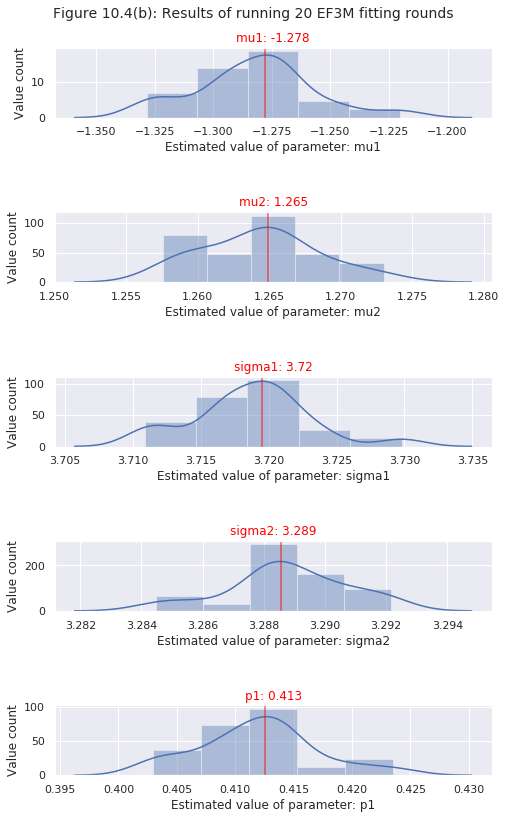

In [117]:
n_runs = 20
m2n = M2N(raw_mmnts)
df_10_4 = m2n.mpFit(raw_mmnts, epsilon=10**-5, factor=5, n_runs=n_runs, variant=2, maxIter=10_000_000)

# 참고
# https://github.com/jo-cho/research/blob/master/Chapter10/Chapter10_Exercises.ipynb

# Visualize results and determine the most likely values from a KDE plot
# ======================================================
fig_10_4b, ax_10_4b = plt.subplots(nrows=5, ncols=1, figsize=(8,12))
cols = ['mu1', 'mu2', 'sigma1', 'sigma2', 'p1']
bins = int(n_runs / 4)  # to minimize number of bins without results, choose at own discretion
fit_parameters = []

print(f"=== Values chosen based on the mode of the distribution of results from EF3M ({n_runs} runs) ===")

for col_i, ax in enumerate(ax_10_4b.flatten()):
    col = cols[col_i]
    df = df_10_4.copy()
    df[col+'_bin'] = pd.cut(df[col], bins=bins)
    df = df.groupby([col+'_bin']).count()
    ax = sns.distplot(df_10_4[col], bins=bins, kde=True, ax=ax)
    dd = ax.get_lines()[0].get_data()
    most_probable_val = dd[0][np.argmax(dd[1])]
    fit_parameters.append(most_probable_val)
    ax.set_ylabel("Value count")
    ax.set_xlabel(f"Estimated value of parameter: {col}")
    ax.axvline(most_probable_val, color='red', alpha=0.6)
    ax.set_title(f"{col}: {round(most_probable_val,3)}", color='red')
    print(f"Most probable estimate for parameter '{col}':", round(dd[0][np.argmax(dd[1])], 3))
fig_10_4b.suptitle(f"Figure 10.4(b): Results of running {n_runs} EF3M fitting rounds", fontsize=14)
fig_10_4b.tight_layout(pad=3.5)
plt.show()

In [118]:
# ef3m 알고리즘을 사용하여 parameter를 구한 결과

fit_parameters 

[-1.2778220443000434,
 1.2649434463226872,
 3.719519248817824,
 3.2885615850438676,
 0.41257874054295174]

In [119]:
cdf_mixture(c,fit_parameters)

array([0.57597653, 0.46748578, 0.36278127, ..., 0.36278127, 0.26875338,
       0.57597653])

### (c) 

$$m_t = \begin{cases}
  \frac{F[c_t]-F[0]}{1-F[0]} & \text{if}\ c_t \ge 0 \\
  \frac{F[c_t]-F[0]}{F[0]} & \text{if}\ c_t < 0
\end{cases}$$

In [0]:
#위의 식

def bet_size_mixed(c_t, parameters):
    # return the bet size based on the description provided in
    # question 10.4(c).
    # :param c_t: (int) different of the number of concurrent long bets minus short bets
    # :param parameters: (list) mixture parameters, [mu1, mu2, sigma1, sigma2, p1]
    # :return: (float) bet size
    # =========================
    if c_t >= 0:
        return ( cdf_mixture(c_t, parameters) - cdf_mixture(0, parameters) ) / ( 1 - cdf_mixture(0, parameters) )
    else:
        ( cdf_mixture(c_t, parameters) - cdf_mixture(0, parameters) ) / cdf_mixture(0, parameters)

In [121]:
bet_size_3 = pd.Series()
bet_size_3 = df_events_4.c_t.apply(lambda c: bet_size_mixed(c, fit_parameters))
bet_size_3

1992-08-22    0.203733
1992-08-23    0.000000
1992-08-24         NaN
1992-08-25    0.000000
1992-08-26    0.203733
                ...   
2020-01-03         NaN
2020-01-04         NaN
2020-01-05         NaN
2020-01-06         NaN
2020-01-07    0.203733
Name: c_t, Length: 10000, dtype: float64

In [122]:
df_events['bet_size_3'] = bet_size_3
df_events.head()

,t1,p,bet_size,avg_active_bets,bet_size_2,bet_size_3
1992-08-22,1992-09-04,0.699504,0.336546,0.336546,0.076923,0.203733
1992-08-23,1992-09-11,0.293278,-0.350222,-0.006838,0.010256,0.000000
1992-08-24,1992-08-26,0.234583,-0.468928,-0.160868,-0.056410,NaN
1992-08-25,1992-08-26,0.555802,0.089418,-0.098296,0.020513,0.000000
1992-08-26,1992-09-14,0.722274,0.380306,0.122210,0.087179,0.203733


/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Text(0.5, 1.0, 'Figure 10.4(c): Bet Size distributions')

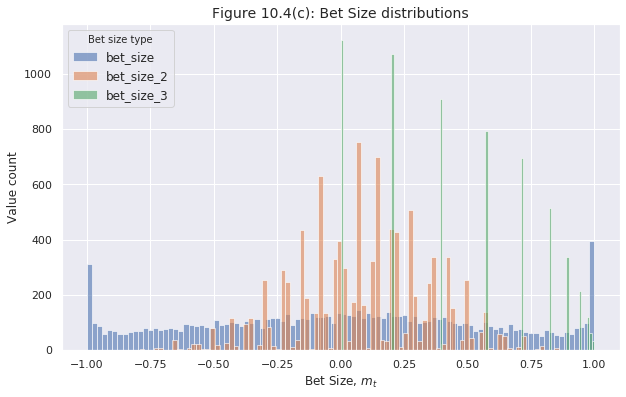

In [126]:
# bet size distrubutions

fig_10_4c, ax_10_4c = plt.subplots(figsize=(10,6))
for c in ['bet_size','bet_size_2', 'bet_size_3']:
    ax_10_4c.hist(df_events[c],  label=c, alpha=0.6, bins=100)
ax_10_4c.legend(loc='upper left', fontsize=12, title="Bet size type", title_fontsize=10)
ax_10_4c.set_xlabel("Bet Size, $m_t$", fontsize=12)
ax_10_4c.set_ylabel("Value count", fontsize=12)
ax_10_4c.set_title("Figure 10.4(c): Bet Size distributions", fontsize=14)

### 5. Repeat exercise 1, where you discretize m with a stepSize=.01 stepSize=.05, and stepSize=.1.

In [0]:
def discreteSignal(signal0,stepSize):
  
  # discretize signal
  signal1=(signal0/stepSize).round()*stepSize # discretize
  signal1[signal1>1]=1 # cap
  signal1[signal1<-1]=-1 # floor
  
  return signal1

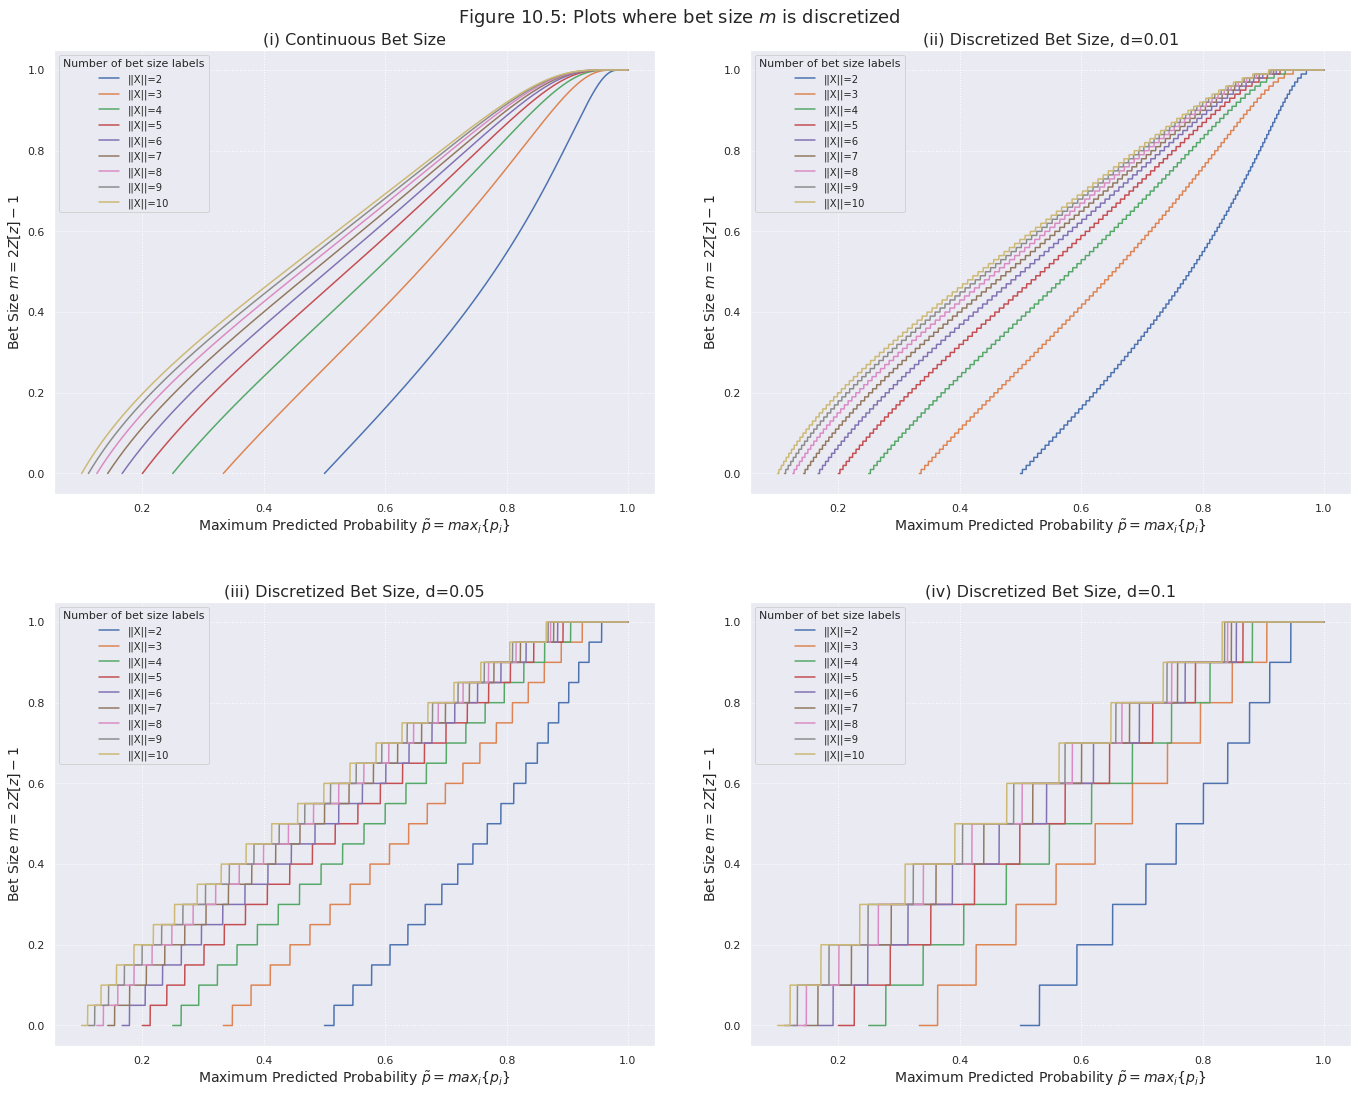

In [130]:
# exercise 1
listX = range(2, 11)  # array of IIXII
n = 10000

fig_10_5, ax_10_5 = plt.subplots(2, 2, figsize=(20, 16))
ax_10_5 = fig_10_5.get_axes()
d_list = [None, 0.01, 0.05, 0.1]
sub_fig_num = ['i', 'ii', 'iii', 'iv']

for i, axi in enumerate(ax_10_5):
    #colors = iter(cm.coolwarm(np.linspace(0,1,len(num_classes_list))))
    for X in listX:
        d = d_list[i]
        # possible range for maximum predicted probability, [1/||X||, 1]
        P = np.linspace( 1/X, 1, n, endpoint=False)  # range of maximum predicted probabilities to plot
        z = (P - 1/X) / (P*(1-P))**0.5
        m = 2 * norm.cdf(z) - 1
        if not isinstance(d, type(None)):
            m = (m/d).round()*d
        axi.plot(P, m, label=f"||X||={X}")

    axi.set_ylabel("Bet Size $m=2Z[z]-1$", fontsize=14)
    axi.set_xlabel(r"Maximum Predicted Probability $\tilde{p}=max_i${$p_i$}", fontsize=14)
    #axi.set_xticks([0.1*i for i in range(11)])
    #axi.set_yticks([0.1*i for i in range(11)])
    axi.legend(loc="upper left", fontsize=10, title="Number of bet size labels", title_fontsize=11)
    #axi.set_ylim((0,1.05))
    #axi.set_xlim((0, 1.05))
    if not isinstance(d, type(None)):
        axi.set_title(f"({sub_fig_num[i]}) Discretized Bet Size, d={d}", fontsize=16)
    else:
        axi.set_title(f"({sub_fig_num[i]}) Continuous Bet Size", fontsize=16)
    axi.grid(linewidth=1, linestyle=':')

fig_10_5.suptitle("Figure 10.5: Plots where bet size $m$ is discretized", fontsize=18)
fig_10_5.tight_layout(pad=4)
plt.show()

In [0]:
def discreteSignal(signal0,stepSize):
  # discretize signal
  signal1=(signal0/stepSize).round()*stepSize # discretize
  signal1[signal1>1]=1 # cap
  signal1[signal1<-1]=-1 # floor
  return signal1

In [138]:
# 한 김에 위에서 구한 bet size의 discrete version도 구해보자

signal0 = df_events['avg_active_bets']
discrete_signal = discreteSignal(signal0, stepSize=0.05)
df_events['discrete_signal'] = discrete_signal
df_events.head()

,t1,p,bet_size,avg_active_bets,bet_size_2,bet_size_3,discrete_signal
1992-08-22,1992-09-04,0.699504,0.336546,0.336546,0.076923,0.203733,0.35
1992-08-23,1992-09-11,0.293278,-0.350222,-0.006838,0.010256,0.000000,-0.00
1992-08-24,1992-08-26,0.234583,-0.468928,-0.160868,-0.056410,NaN,-0.15
1992-08-25,1992-08-26,0.555802,0.089418,-0.098296,0.020513,0.000000,-0.10
1992-08-26,1992-09-14,0.722274,0.380306,0.122210,0.087179,0.203733,0.10


## 6. Rewrite the equations in Section 10.6, so that the bet size is determined by a power function rather than a sigmoid function.

Let's see what we got in Section 10.6

Let $q_t$ be the current position, $Q$ the maximum absolute position size, and ̂$q_{i,t}$ the target position size associated with forecast $f_i$, such that

$$\hat{q}_{i,t} = \text{int}[m[\omega,f_i − p_t]Q]\\
m[\omega, x] = \frac{x}{\sqrt{𝜔 + x^2}}$$

where m[𝜔, x] is the bet size, x = fi − pt is the divergence between the current market
price and the forecast, 𝜔 is a coefficient that regulates the width of the sigmoid function,
and Int [x] is the integer value of x. Note that for a real-valued price divergence
x, −1 < m[𝜔, x] < 1, the integer value $\hat{q}_{i,t}$ is bounded −Q < ̂qi,t < Q.

The target position size ̂qi,t can be dynamically adjusted as pt changes. In particular,
as pt → fi we get ̂qi,t → 0, because the algorithm wants to realize the gains. This implies a breakeven limit price ̄p for the order size ̂qi,t − qt, to avoid realizing losses. In particular,

$$ \hat{p} = \frac{1}{q_{i,t} − q_{t}} \displaystyle\sum_{j=\mid q_t+sgn[\hat{q}_{i,t}-q_t]\mid}^{\mid\hat{q}_{i,t}\mid}{L[f_i,\omega,\frac{j}{Q}]} $$

where L[fi,𝜔,m] is the inverse function of m[𝜔, fi − pt] with respect to pt,

$$ L[f_i,𝜔,m] = f_i − m\sqrt{\frac{𝜔}{1−m^2}} $$

We do not need to worry about the case m^2 = 1, because $|\hat{q}_i,t| < 1$. Since this
function is monotonic, the algorithm cannot realize losses as pt → fi.

Let us calibrate $𝜔$. Given a user-defined pair $(x,m^∗)$, such that $x = f_i − p_t$ and $m^∗ = m[𝜔, x]$, the inverse function of m[𝜔, x] with respect to 𝜔 is
$$
𝜔 = x^2(m^{∗−2} − 1)
$$

In [0]:
# Now let us rewrite
# 이것도 역시 hudson-thames 출처


We can substitute a power function to calculate bet size, $\tilde{m}$:

$$\tilde{m}[\omega, x] = sgn[x]|x|^\omega$$
$L[f_i, \omega, \tilde{m}]$, the inverse function of $\tilde{m}[\omega, x]$ with respect to the market price $p_t$, can be rewritten as:

$$L[f_i, \omega, \tilde{m}] = f_i - sgn[\tilde{m}]|\tilde{m}|^{1/\omega}$$
The inverse of $\tilde{m}[\omega, x]$ with respect to $\omega$ can be rewritten as:

$$\omega = \frac{log[\frac{\tilde{m}}{sgn(x)}]}{log[|x|]}$$
Where $x = f_i - p_t$ is still the divergence between the current market price, $p_t$, and the price forecast, $f_i$.

## 7. Modify Snippet 10.4 so that it implements the equations you derived in exercise 6


In [0]:
# Snippet 10.4

def betSize(w,x):
  return x*(w+x**2)**-.5
#———————————————————————————————————————
def getTPos(w,f,mP,maxPos):
  return int(betSize(w,f-mP)*maxPos)
#———————————————————————————————————————
def invPrice(f,w,m):
  return f-m*(w/(1-m**2))**.5
#———————————————————————————————————————
def limitPrice(tPos,pos,f,w,maxPos):
  sgn=(1 if tPos>=pos else -1)
  lP=0
  for j in range(abs(pos+sgn),abs(tPos+1)):
    lP+=invPrice(f,w,j/float(maxPos))
  lP/=tPos-pos
  return lP
#———————————————————————————————————————
def getW(x,m):
  # 0<alpha<1
  return (x**2)*((m**(-2))-1)
#———————————————————————————————————————
def main():
  pos,maxPos,mP,f,wParams=0,100,100,115,{'divergence':10,'m':.95}
  w=getW(wParams['divergence'],wParams['m']) # calibrate w
  tPos=getTPos(w,f,mP,maxPos) # get tPos
  lP=limitPrice(tPos,pos,f,w,maxPos) # limit price for order
  return w, tPos, lP
#———————————————————————————————————————
if __name__=='__main__':main()


In [154]:
a = ['w', 'tPos', 'lP']
for i in range(len(a)):
    print(a[i],'=',main()[i])

w = 10.803324099723
tPos = 97
lP = 112.36573855883363


Let us modify

In [0]:
# New one

def betSize2(w,x):
  return np.sign(x)*(np.abs(x)**w)
#———————————————————————————————————————
def getTPos2(w,f,mP,maxPos):
  return int(betSize2(w,f-mP)*maxPos)
#———————————————————————————————————————
def invPrice2(f,w,m):
  return f-np.sign(m)*(np.abs(m)**(1/w))
#———————————————————————————————————————
def limitPrice2(tPos,pos,f,w,maxPos):
  sgn=(1 if tPos>=pos else -1)
  lP=0
  for j in range(abs(pos+sgn),abs(tPos+1)):
    lP+=invPrice2(f,w,j/float(maxPos))
  lP/=tPos-pos
  return lP
#———————————————————————————————————————
def getW2(x,m):
  # 0<alpha<1
  return np.log(m/np.sign(x))/np.log(np.abs(x))
#———————————————————————————————————————
def main2():
  pos,maxPos,mP,f,wParams=0,100,100,115,{'divergence':10,'m':.95}
  w=getW2(wParams['divergence'],wParams['m']) # calibrate w
  tPos=getTPos2(w,f,mP,maxPos) # get tPos
  lP=limitPrice2(tPos,pos,f,w,maxPos) # limit price for order
  return w, tPos, lP
#———————————————————————————————————————
if __name__=='__main__':main()

In [152]:
a = ['w', 'tPos', 'lP']
for i in range(len(a)):
    print(a[i],'=',main2()[i])

w = -0.02227639471115225
tPos = 94
lP = -6.426982348112109e+87


# Further study

In [0]:
# 실제 E-mini future data를 가지고 실험해보자.

In [0]:
def getSignal(events,stepSize,prob,pred,numClasses,numThreads,**kargs):
  # get signals from predictions
  if prob.shape[0]==0:return pd.Series()
  #1) generate signals from multinomial classification (one-vs-rest, OvR)
  signal0=(prob-1./numClasses)/(prob*(1.-prob))**.5 # t-value of OvR
  signal0=pred*(2*norm.cdf(signal0)-1) # signal=side*size
  if 'side' in events:signal0*=events.loc[signal0.index,'side'] # meta-labeling
  #2) compute average signal among those concurrently open
  df0=signal0.to_frame('signal').join(events[['t1']],how='left')
  df0=avgActiveSignals(df0,numThreads)
  signal1=discreteSignal(signal0=df0,stepSize=stepSize)
  return signal1

In [155]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [156]:
!pip install -q mlfinlab
from mlfinlab import data_structures, features, filters, labeling, util

     |████████████████████████████████| 122kB 6.4MB/s 


In [157]:
raw_dollar_bars = data_structures.get_dollar_bars('/content/drive/My Drive/Colab Notebooks/csv/clean_IVE_tickbidask2.csv', threshold=1000000)
dollar_bars = raw_dollar_bars.set_index(pd.to_datetime(raw_dollar_bars.date_time))
dollar_bars = dollar_bars.drop(columns='date_time')
dollar_bars = dollar_bars.reset_index().drop_duplicates(subset='date_time', keep='last').set_index('date_time')

Reading data in batches:
Batch number: 0
Returning bars 



In [158]:
close = dollar_bars.close
pt_sl = [1,1]
target = util.get_daily_vol(close)
h = target.mean()
t_events = filters.cusum_filter(close,h)
vertical_barrier_times = labeling.add_vertical_barrier(t_events,close,num_days=1)

fast_window = 20
slow_window = 50

df = pd.DataFrame()
df['fast_mavg'] = close.rolling(window=fast_window, min_periods=fast_window, center=False).mean()
df['slow_mavg'] = close.rolling(window=slow_window, min_periods=slow_window, center=False).mean()
df['side'] = np.nan

long_signals = df['fast_mavg'] >= df['slow_mavg'] 
short_signals = df['fast_mavg'] < df['slow_mavg'] 
df.loc[long_signals, 'side'] = 1
df.loc[short_signals, 'side'] = -1

df['side'] = df['side'].shift(1)

side = df['side']

events = labeling.get_events(close, t_events, pt_sl, target, min_ret=0.005, num_threads=1, vertical_barrier_times = vertical_barrier_times ,side_prediction = side)
bin = labeling.get_bins(events,close)

/usr/local/lib/python3.6/dist-packages/mlfinlab/labeling/labeling.py:124: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  target = target.loc[t_events]


In [160]:
bin

,ret,trgt,bin,side
2009-09-30 09:44:47,NaN,0.005038,0,NaN
2009-09-30 09:56:31,NaN,0.006797,0,NaN
2009-09-30 12:48:14,NaN,0.008708,0,NaN
2009-09-30 15:05:38,0.009887,0.008165,1,-1.0
2009-10-01 09:52:26,0.009346,0.008035,1,-1.0
...,...,...,...,...
2019-06-12 10:18:41,0.003304,0.006636,0,1.0
2019-06-17 09:57:13,0.006604,0.005434,1,1.0
2019-06-18 09:39:43,-0.006916,0.005908,0,-1.0
2019-06-20 09:30:00,-0.007390,0.005475,0,1.0


In [0]:
getSignal(events,stepSize=0.01,prob=,pred=,numClasses=,numThreads=)